In [1]:
import numpy as np
from qiskit import Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [111]:
# set the length of the n-bit input string. 
n = 3

In [112]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
print(output)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

1


q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

In [113]:
balanced_oracle = QuantumCircuit(n+1)

In [114]:
b_str = "101"

In [121]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "000"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)
# balanced_oracle.cx(qubit, 1)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

░                 ░ 
q_0: ─░───■─────────────░─
      ░   │             ░ 
q_1: ─░───┼────■────────░─
      ░   │    │        ░ 
q_2: ─░───┼────┼────■───░─
      ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ─░─┤ X ├┤ X ├┤ X ├─░─
      ░ └───┘└───┘└───┘ ░

In [122]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
display(dj_circuit.draw())
# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
display(dj_circuit.draw())

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘
q_3: ─────
          
c: 3/═════

/var/folders/92/jjpjrbf91clg0kmcnqglv1ym0000gn/T/ipykernel_76716/4181410275.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


┌───┐      ░                 ░ ┌───┐ ░ ┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├─░─┤M├──────
     ├───┤      ░   │             ░ ├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├─░──╫─┤M├───
     ├───┤      ░   │    │        ░ ├───┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼────┼────■───░─┤ H ├─░──╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░───────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░       ░  ║  ║  ║ 
c: 3/════════════════════════════════════════╩══╩══╩═
                                             0  1  2

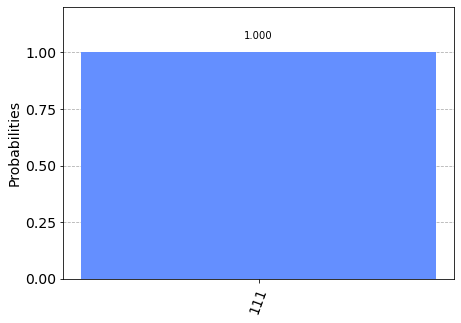

In [123]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

### Deutsch Josza

In [148]:
def dj_oracle(case, n, b, oracle_type="one"):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates: 
        
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        if oracle_type=="one":
          for qubit in range(n):
              oracle_qc.cx(qubit, n)
        else:
          oracle_qc.cx(0, n)
          oracle_qc.cx(2, n)
          oracle_qc.cx(3, n)
          oracle_qc.cx(4, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.draw()
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [149]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [150]:
list(answer.keys())

['01101']

In [151]:
from tqdm import tqdm

In [152]:
all_results = {}
n = 5
for i in tqdm(range(2**n)):
  oracle_gate = dj_oracle('balanced', n, i, oracle_type=3)
  dj_circuit = dj_algorithm(oracle_gate, n)
  dj_circuit.draw()
  transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
  qobj = assemble(transpiled_dj_circuit, shots=10)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  all_results[i] = list(answer.keys())

100%|██████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.08it/s]


In [153]:
print(all_results)

{0: ['11101'], 1: ['11101'], 2: ['11101'], 3: ['11101'], 4: ['11101'], 5: ['11101'], 6: ['11101'], 7: ['11101'], 8: ['11101'], 9: ['11101'], 10: ['11101'], 11: ['11101'], 12: ['11101'], 13: ['11101'], 14: ['11101'], 15: ['11101'], 16: ['11101'], 17: ['11101'], 18: ['11101'], 19: ['11101'], 20: ['11101'], 21: ['11101'], 22: ['11101'], 23: ['11101'], 24: ['11101'], 25: ['11101'], 26: ['11101'], 27: ['11101'], 28: ['11101'], 29: ['11101'], 30: ['11101'], 31: ['11101']}


* A balanced function that outputs a value f(x)=**p** for x with even 1s and f(x)=**q** for x with odd ones gives a final measurement value of 1111...1

* The 1s have to match at the respective positions.
* Every z has a mapping for x.z, and if the numbers f(x) all equal f(x) or all equal the complement of x, then that is the amplitude that is finally shown 